In [1]:
from conf import databases, data_dir
from nn import load_lasagne_nn
from prepostproc import stepize_x, unstepize
from rpeaks import compute_best_peak

import numpy
import time

from matplotlib import pyplot as plt
import matplotlib as mpl

Using gpu device 0: GeForce GTX 1050 Ti (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5110)
/home/jdu/anac3.5/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
save_name = 'saved-models/mitdb_stdb_svdb2017-05-27-05-31'
json_name = save_name + '.json'
weights_name = save_name + '/epoch82.loss0.081802.weights'
info, nn = load_lasagne_nn(json_name, weights_name)
params = info['params']
dim = info['dim']
architecture = info['arch']

Model shape:
  Layer 0:
    - size: 3	num: 8
    - size: 7	num: 32
    - size: 9	num: 32
    - size: 15	num: 32
    - size: 99	num: 32
    - size: 299	num: 32
    - size: 499	num: 32
    - dropout: 0.5
  Layer 1:
    - size: 3	num: 8
    - size: 5	num: 32
    - size: 9	num: 32
    - size: 25	num: 32
    - size: 99	num: 32
    - size: 199	num: 32
    - dropout: 0.5
  Layer 2:
    - size: 3	num: 8
    - size: 9	num: 32
    - size: 25	num: 32
    - size: 99	num: 32
    - size: 199	num: 32
    - dropout: 0.5
  Layer 3:
    - size: 3	num: 8
    - size: 9	num: 32
    - size: 15	num: 32
    - size: 59	num: 32
    - dropout: 0.5
Neural network initialized in 27.59s


In [20]:
import wfdb
from sklearn.metrics import roc_curve

def process_example(x, nn, params):
    X = stepize_x(x, params) # Normalize if necessary
    Y = []
    for example in X:
        Y.append(nn.evaluate_x(example))
    return Y # list of numpy arrays containing raw probabilities from CNN

def fix_margin_eval(true, pred, margin):
    for i in range(len(pred)):
        if pred[i] == 1 and true[i] != pred[i]:
            min_i = max(0, i-margin)
            max_i = min(len(pred), i+margin+1)
            if 1 in true[min_i:max_i]:
                for j in range(min_i, max_i):
                    pred[j] = true[j]
    return true, pred

def disp_range(x, y, lb, ub, title):
    x = x[lb:ub]
    y = y[lb:ub]
    best_peaks_idxs = numpy.where(y==1)[0]
    best_peaks_vals = x[best_peaks_idxs]
    plt.figure(figsize=(20, 4))
    plt.plot(x, 'b')
    plt.plot(best_peaks_idxs, best_peaks_vals, 'r*', markersize=5)
    plt.title(title)
    plt.show()

def eval_example(data_dir, db, ex, nn, params, border_size, nearest_fpr, eval_margin):
    f = '{}/{}/{}'.format(data_dir, db, ex)
    sig, fields = wfdb.srdsamp(f)
    fs = fields['fs']
    ann = wfdb.rdann(f, 'atr')
    
    x = sig[:, 0]
    y_pred = unstepize(process_example(x, nn, params), x.shape[0], params)
    
    y_true_idx = ann.annsamp
    y_true = numpy.zeros(x.shape[0], dtype='int8')
    y_true[y_true_idx] = 1

    if border_size > 0:
        y_true = y_true[border_size:-border_size]
        y_pred = y_pred[border_size:-border_size]
    assert y_true.shape == y_pred.shape and y_true.shape[0] > 0

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
#         for u, v in enumerate(thresholds):
#             print(fpr[u], tpr[u], v)
    best_idx = (numpy.abs(fpr-nearest_fpr)).argmin()
    thresh = thresholds[best_idx]
    thresh = 0.98

    y_pred_idx = compute_best_peak(signal=x, rpeaks=y_pred, min_gap=params['min_gap'], max_gap=params['max_gap'], threshold=thresh)
    y_pred = numpy.zeros(x.shape[0], dtype='float32')
    y_pred[y_pred_idx] = 1

    y_true, y_pred = fix_margin_eval(y_true, y_pred, eval_margin)
    
    rp = numpy.where(y_true==1)[0]
    fp = numpy.where((y_pred-y_true)==1)[0]
    fn = numpy.where((y_true-y_pred)==1)[0]
        
    return x, ann, fs, thresh, y_true, y_pred, rp, fp, fn
    
    
def evaluate_on_db(data_dir, db, examples, nn, params, border_size, nearest_fpr, eval_margin):
    print('Evaluating {} database:'.format(db))
    print('{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}{:>10}'.format('Tape', 'Nb beats', 'FP', 'FN', 'Failed', 'Failed', 'Threshold'))
    tot_ex = len(examples)
    tot_samples = 0
    tot_sec = 0
    tot_beats = 0
    tot_fp = 0
    tot_fn = 0
    tot_thresh = 0
    
    t1 = time.time()
    for ex in examples:
        x, ann, fs, thresh, y_true, y_pred, rp, fp, fn = eval_example(data_dir, db, ex, nn, params, border_size, nearest_fpr, eval_margin)
        #if fp.shape[0] > 0:
        #    disp_range(x, y_pred, fp[0]-2500, fp[0]+2500, title='FP for' + str(ex))
        #if fn.shape[0] > 0:
        #    disp_range(x, y_pred, fn[0]-2500, fn[0]+2500, title='FN for' + str(ex))
        
        rp = len(rp)
        fp = len(fp)
        fn = len(fn)
        
        print('{:>10}{:10d}{:10d}{:10d}{:10d}{:7.2f}%{:8.2f}'.format(ex, rp, fp, fn, fp+fn, (fp+fn)*100/rp, thresh))
#         print('{:.6f}\t\t{:.6f}\+t\t{:.7f}'.format(fpr[idx], tpr[idx], thresholds[idx]))
        
        tot_samples += x.shape[0]
        tot_sec += x.shape[0]/fs
        tot_beats += ann.annsamp.shape[0]
        tot_fp += fp
        tot_fn += fn
        tot_thresh += thresh
        
    tot_failed = tot_fp + tot_fn
    elapsed_secs = time.time() - t1
    
    print('--------------------------------------------------------')
    print('{:>10}{:10d}{:10d}{:10d}{:10d}{:7.2f}%{:8.2f}'.format(
            tot_ex, tot_beats, tot_fp, tot_fn, tot_failed, (tot_failed)*100/rp/tot_ex, tot_thresh/tot_ex))
    print('Computed in {:.2f}seconds (Computed {:.2f}x faster than ECG time)'.format(elapsed_secs, tot_sec/elapsed_secs))

exs = ["100", "101", "102", "103", "104", "105", "106", "107", "108", "109", "111", "112", "113", "114", "115", "116", "117", "118", "119", "121", "122", "123", "124", "200", "201", "202", "203", "205", "207", "208", "209", "210", "212", "213", "214", "215", "217", "219", "220", "221", "222", "223", "228", "230", "231", "232", "233", "234"]
evaluate_on_db('data', 'mitdb', exs, nn, params, border_size=0, nearest_fpr=0.001, eval_margin=20)

Evaluating mitdb database:
      Tape  Nb beats        FP        FN    Failed    Failed Threshold
       100      2274         0         1         1   0.04%    0.98
       101      1874         2         8        10   0.53%    0.98
       102      2192        48        53       101   4.61%    0.98
       103      2091         0         7         7   0.33%    0.98
       104      2311       961       151      1112  48.12%    0.98
       105      2691       101       165       266   9.88%    0.98
       106      2098        12        80        92   4.39%    0.98
       107      2140      1713       371      2084  97.38%    0.98
       108      1824       218       125       343  18.80%    0.98
       109      2535         5         8        13   0.51%    0.98
       111      2133         7        16        23   1.08%    0.98
       112      2550         1        12        13   0.51%    0.98
       113      1796       349         1       350  19.49%    0.98
       114      1890         4 

(650000,) (650000,) (0,)
(650000,) (650000,) (3,)


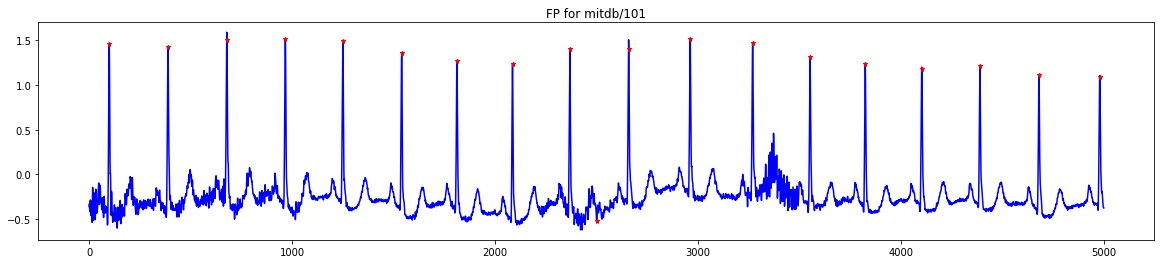

(650000,) (650000,) (48,)


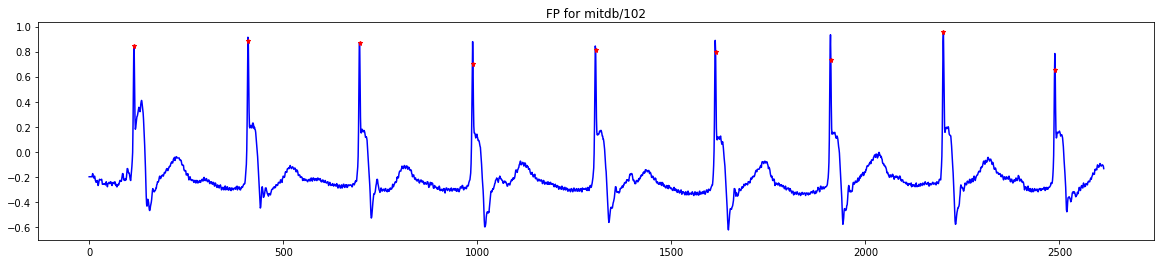

(650000,) (650000,) (1,)


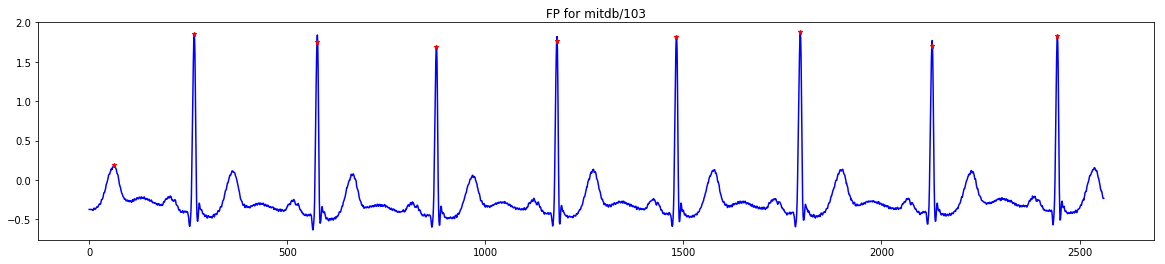

(650000,) (650000,) (976,)


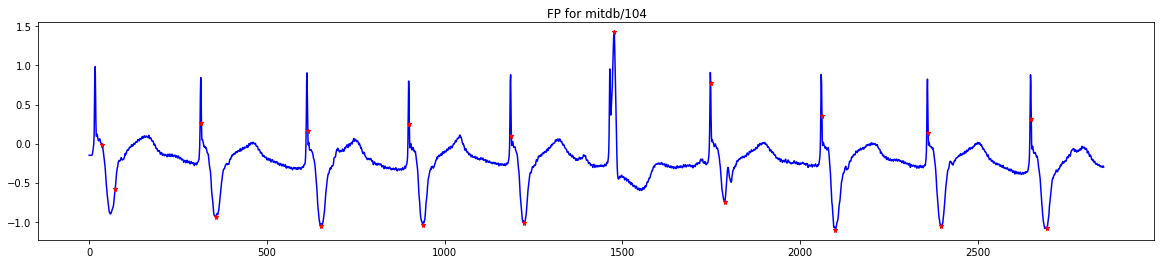

(650000,) (650000,) (92,)


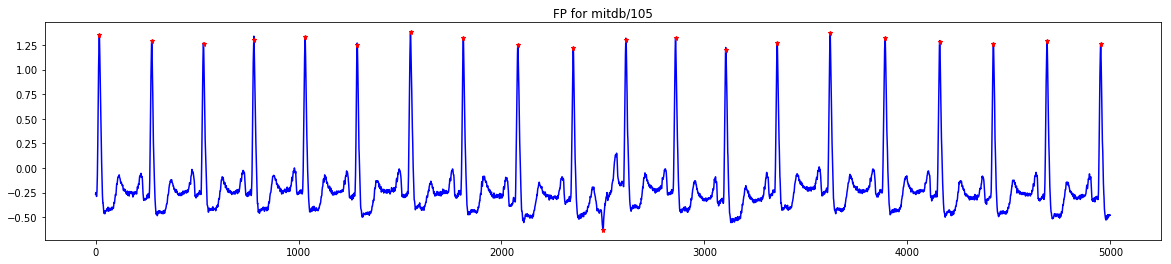

(650000,) (650000,) (13,)


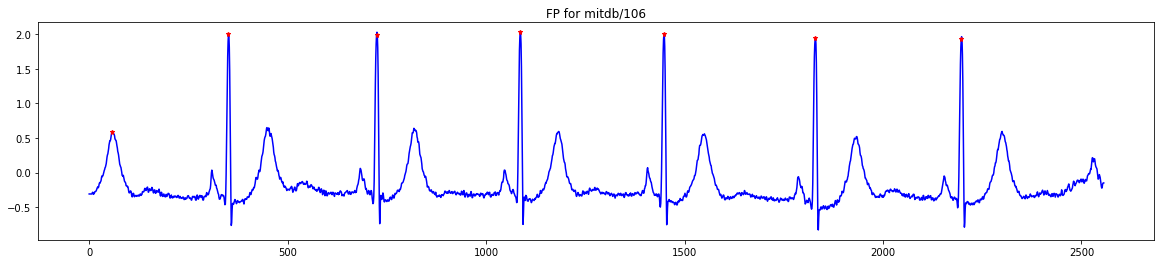

(650000,) (650000,) (1723,)


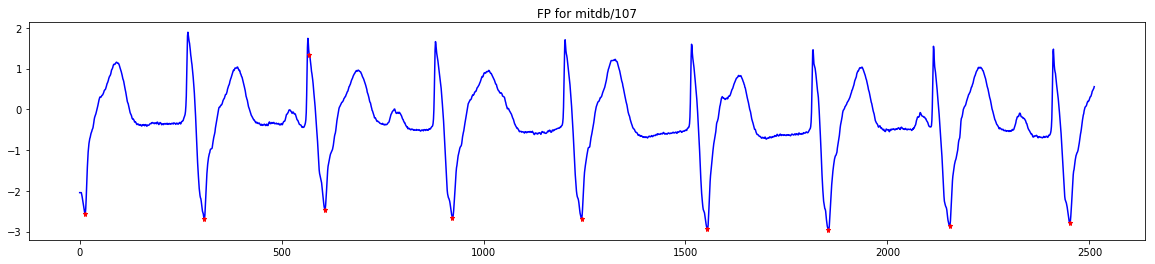

(650000,) (650000,) (233,)


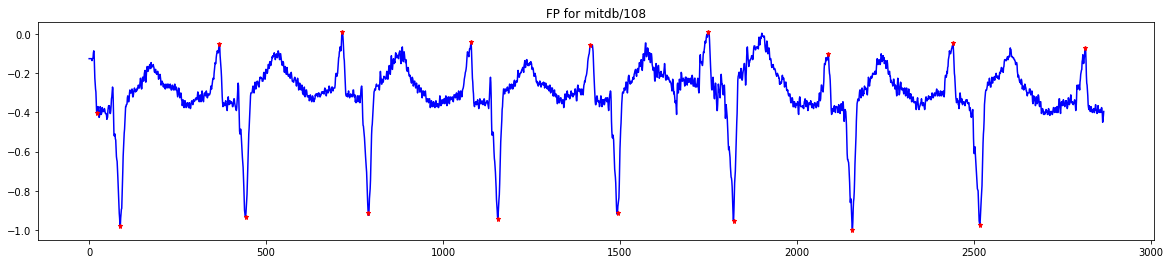

(650000,) (650000,) (5,)


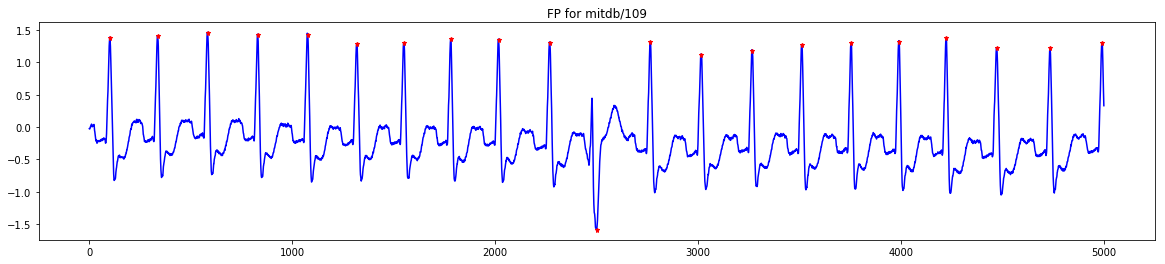

(650000,) (650000,) (6,)


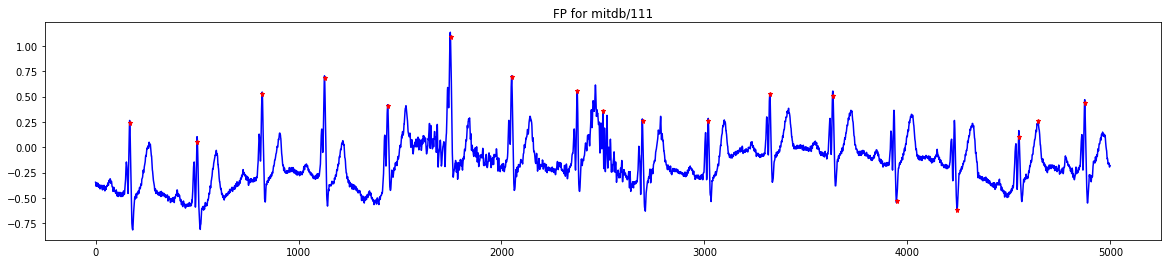

(650000,) (650000,) (5,)


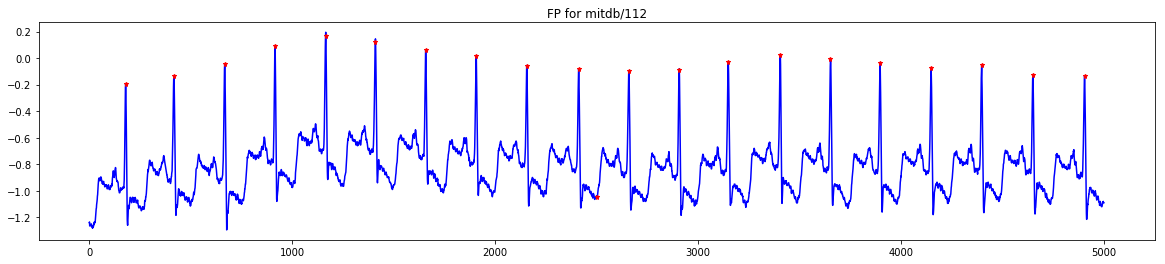

(650000,) (650000,) (389,)


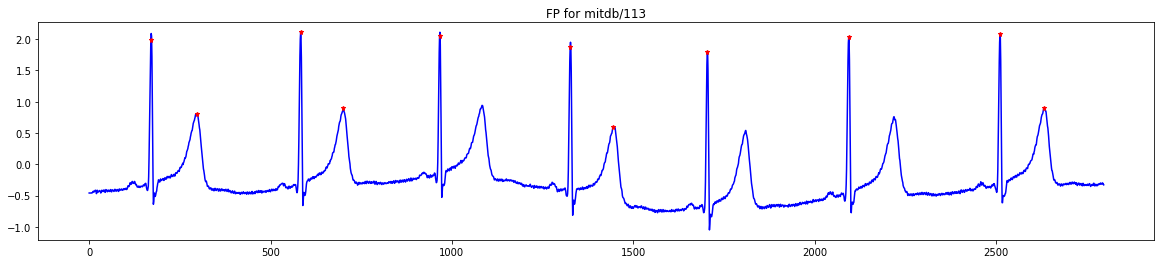

(650000,) (650000,) (4,)


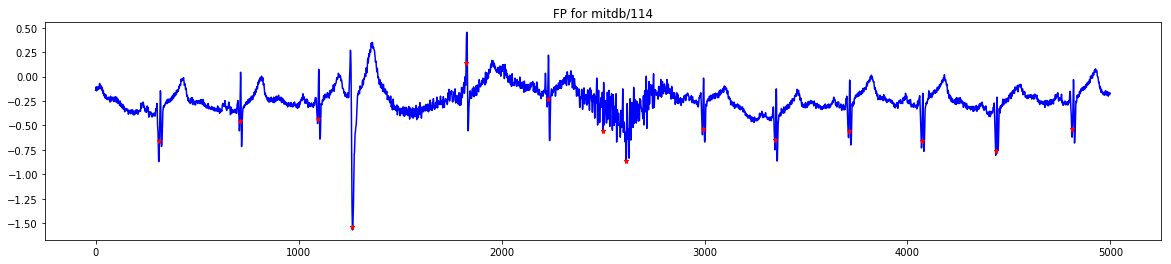

(650000,) (650000,) (1,)


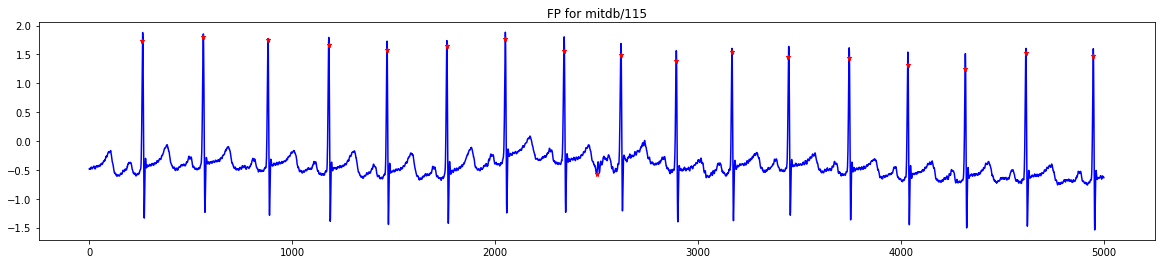

(650000,) (650000,) (4,)


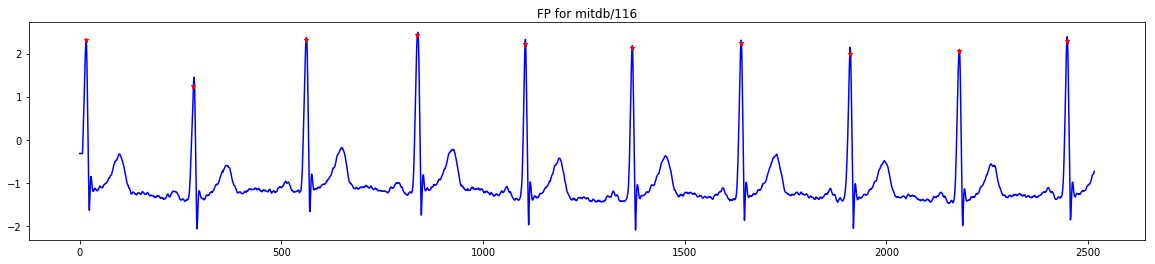

(650000,) (650000,) (3,)


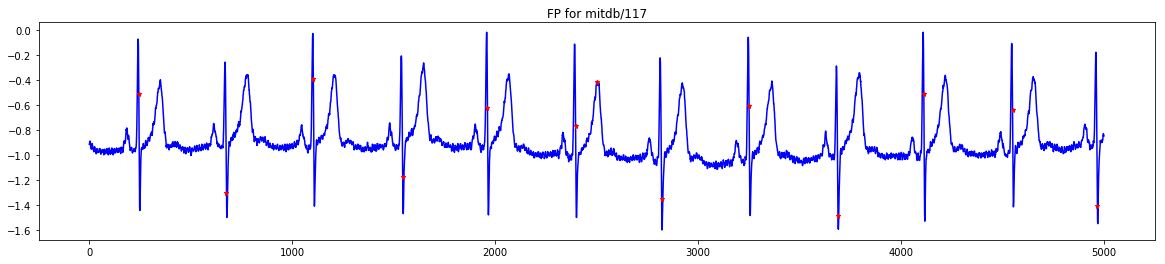

(650000,) (650000,) (16,)


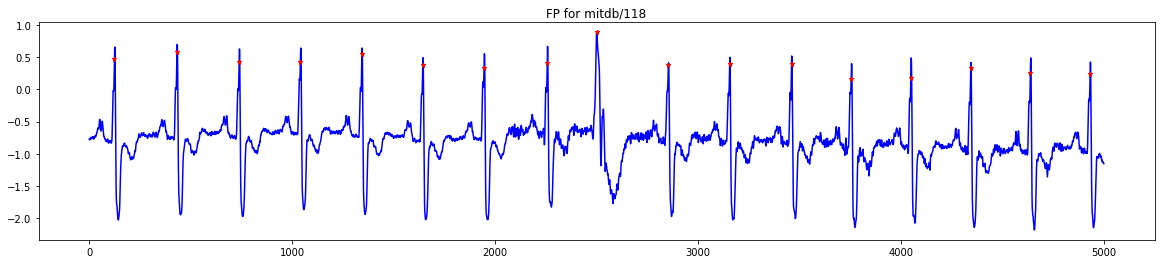

(650000,) (650000,) (1,)


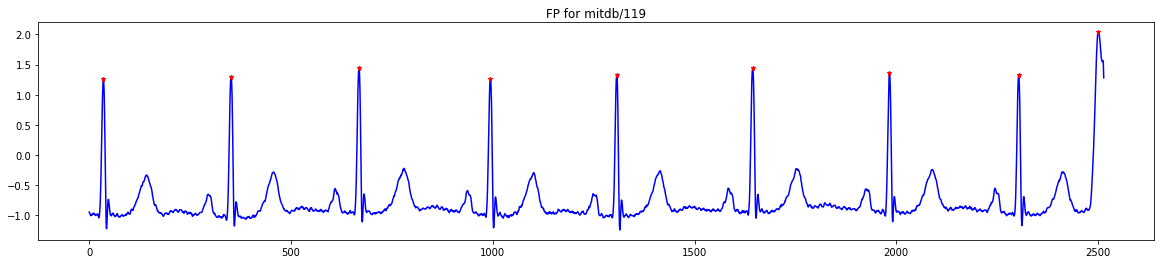

(650000,) (650000,) (9,)


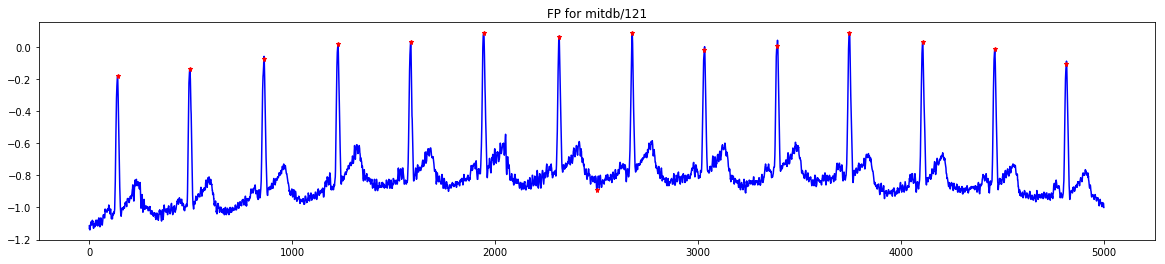

(650000,) (650000,) (0,)
(650000,) (650000,) (3,)


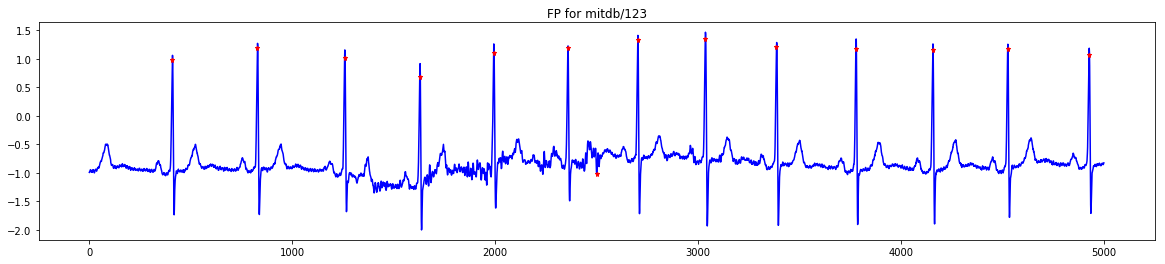

(650000,) (650000,) (8,)


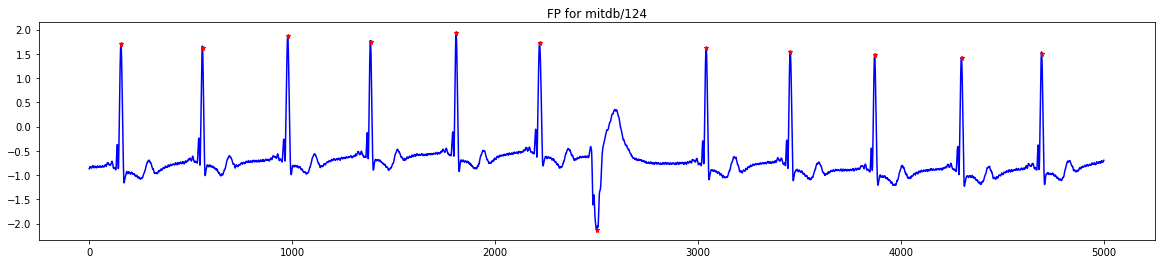

(650000,) (650000,) (21,)


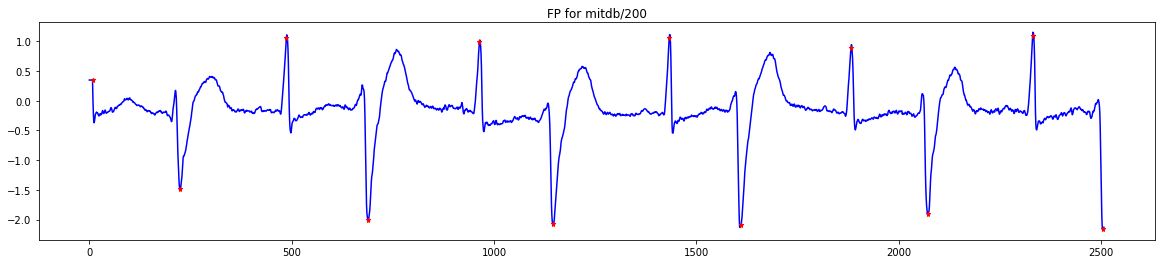

(650000,) (650000,) (16,)


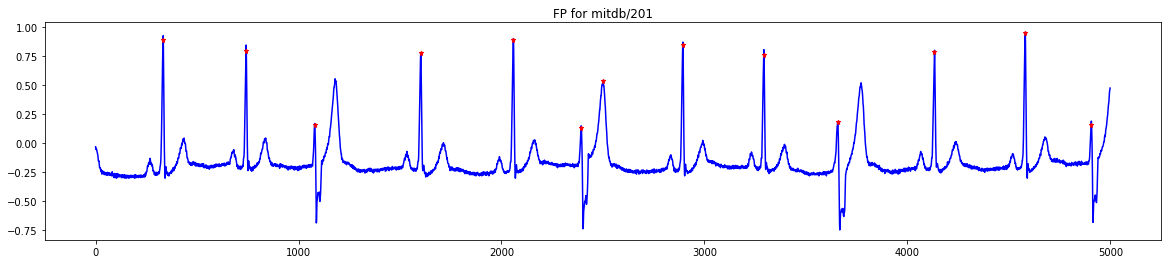

(650000,) (650000,) (12,)


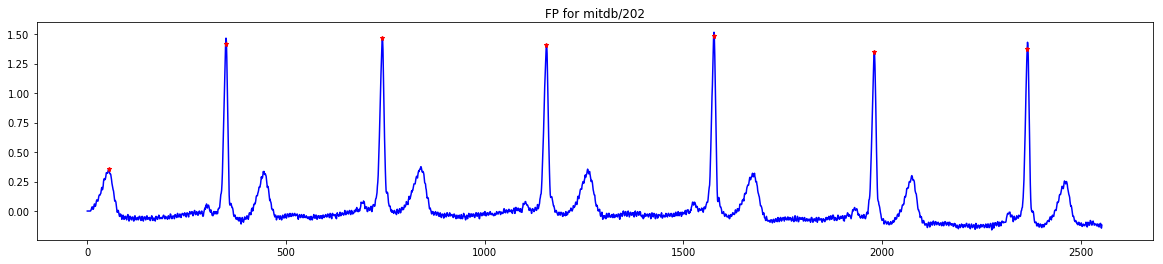

(650000,) (650000,) (31,)


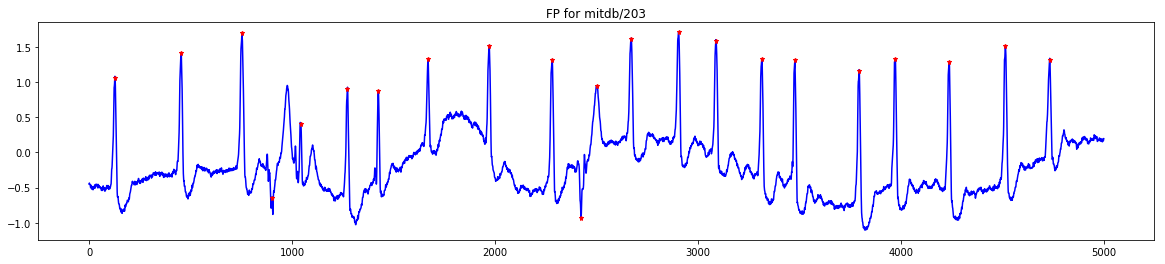

(650000,) (650000,) (1,)


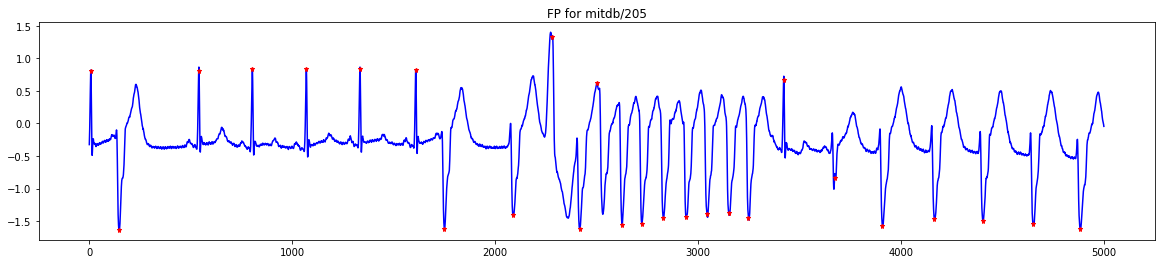

(650000,) (650000,) (113,)


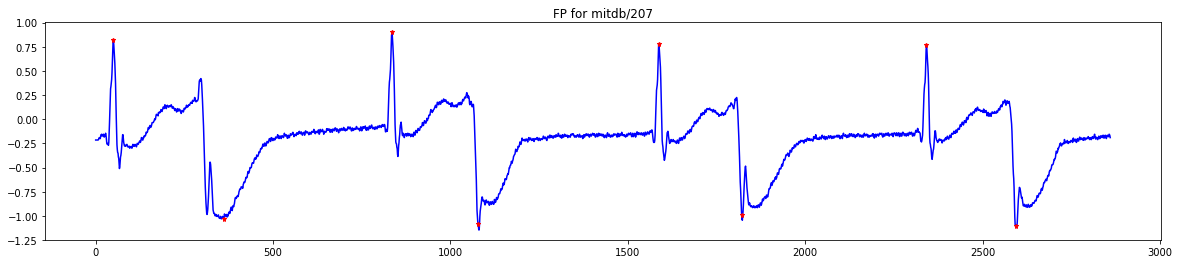

(650000,) (650000,) (8,)


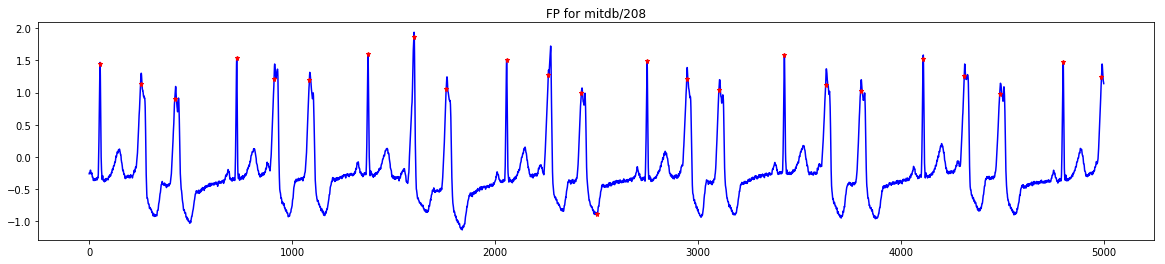

(650000,) (650000,) (1,)


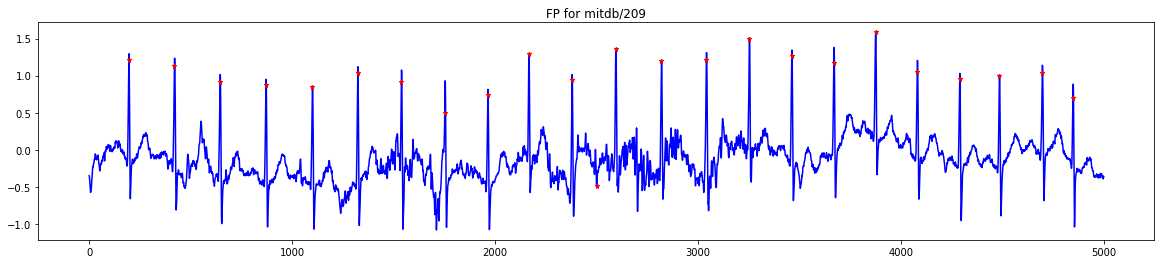

(650000,) (650000,) (2,)


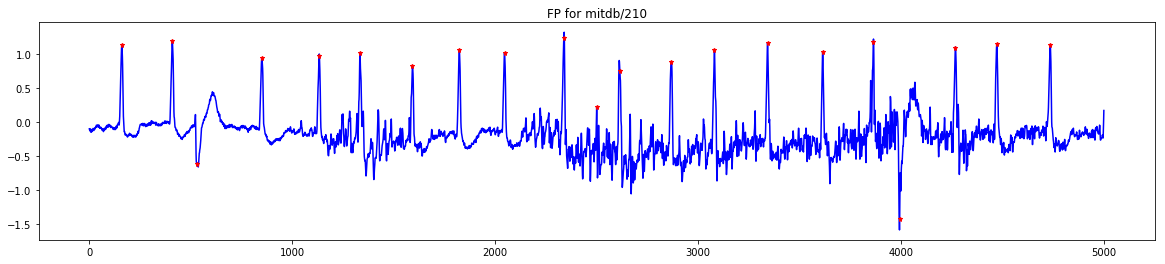

(650000,) (650000,) (2,)


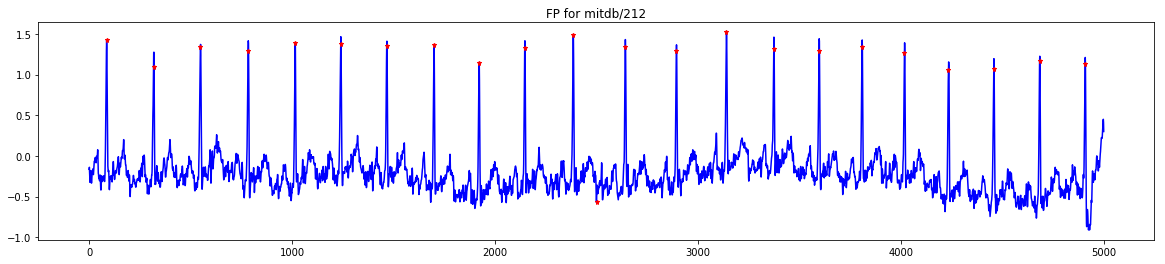

(650000,) (650000,) (1,)


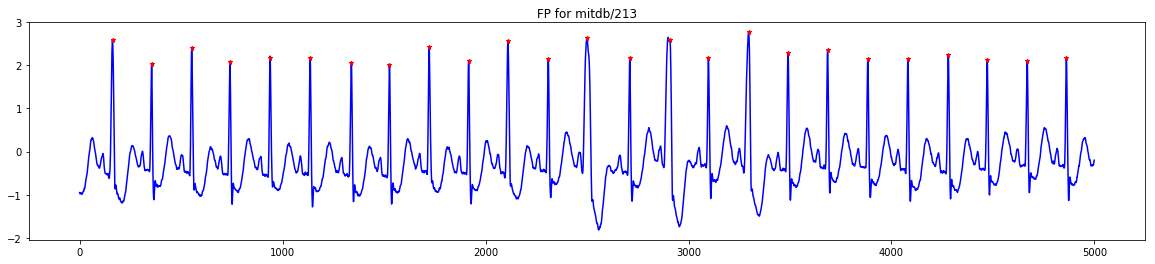

(650000,) (650000,) (98,)


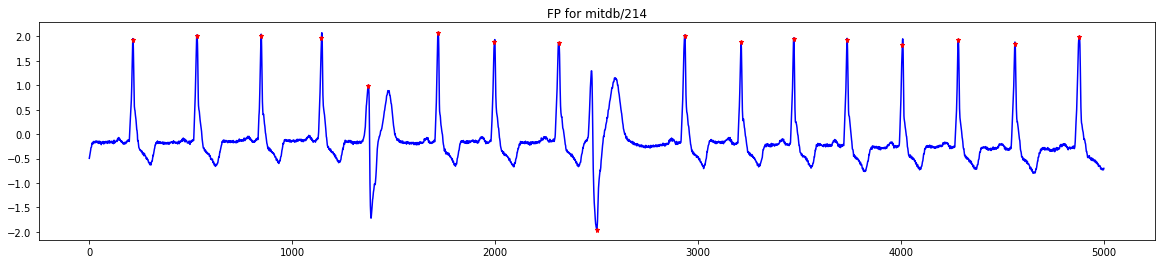

(650000,) (650000,) (2,)


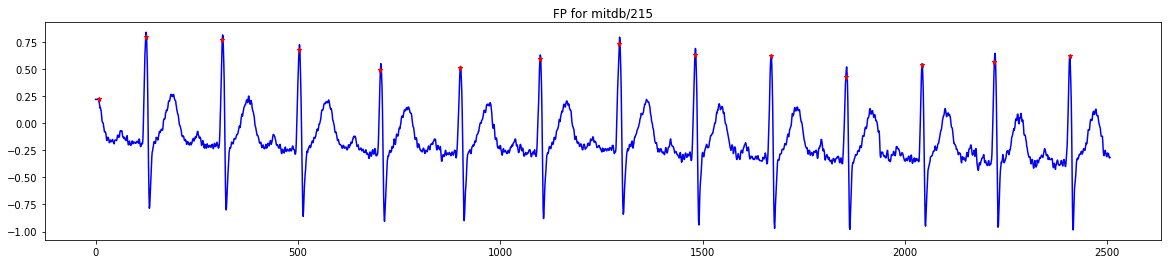

(650000,) (650000,) (1288,)


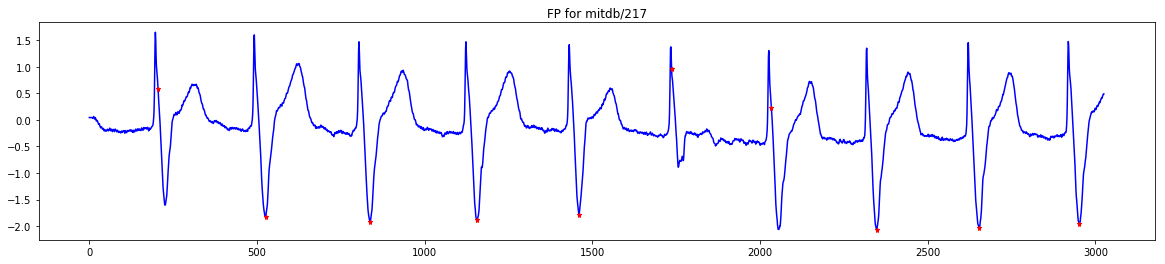

(650000,) (650000,) (2,)


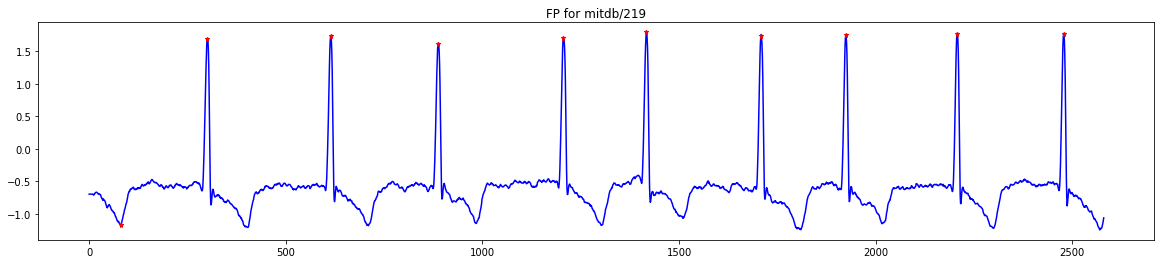

(650000,) (650000,) (0,)
(650000,) (650000,) (2,)


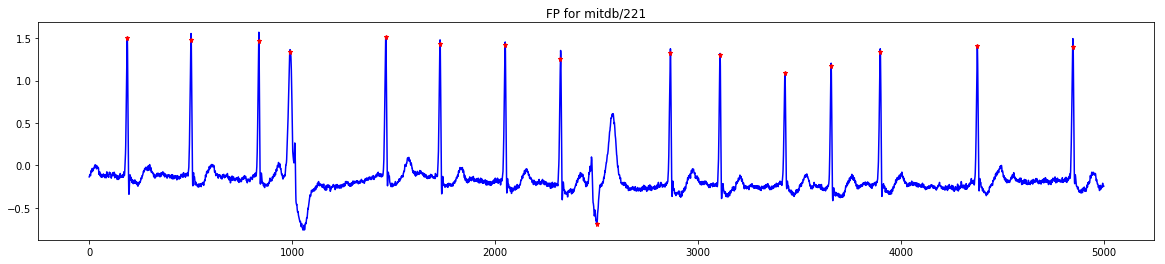

(650000,) (650000,) (128,)


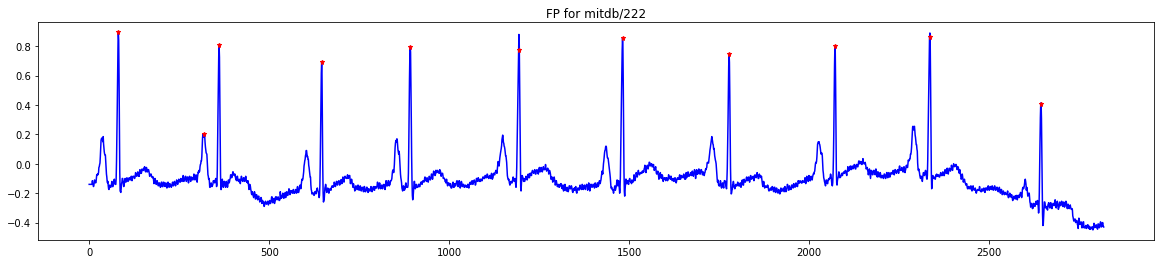

(650000,) (650000,) (2,)


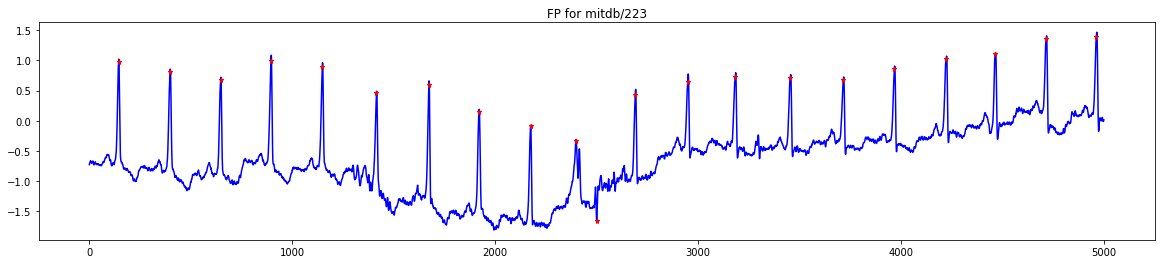

(650000,) (650000,) (58,)


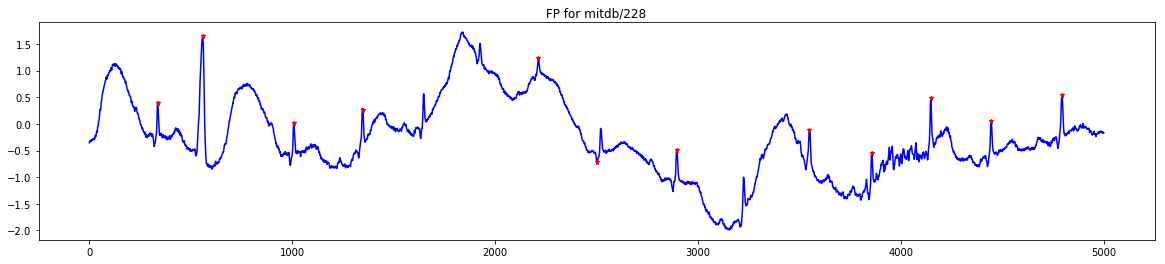

(650000,) (650000,) (1,)


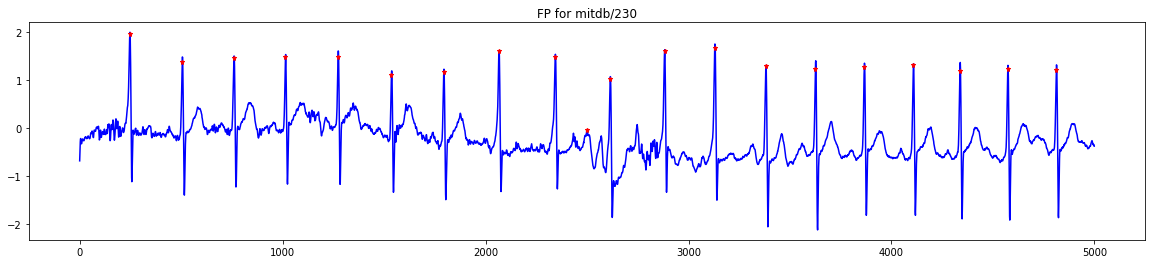

(650000,) (650000,) (4,)


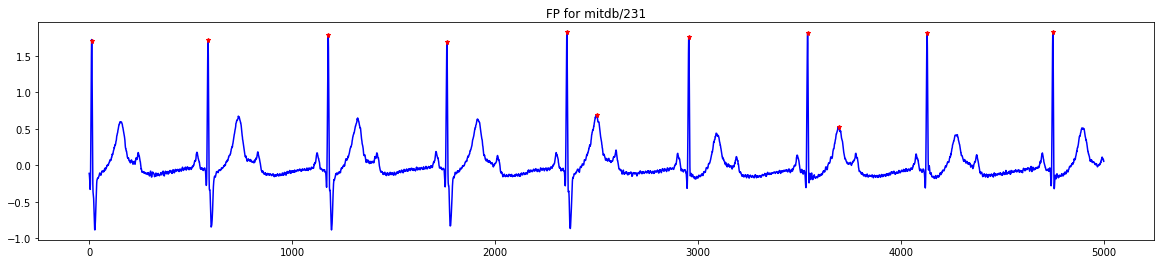

(650000,) (650000,) (45,)


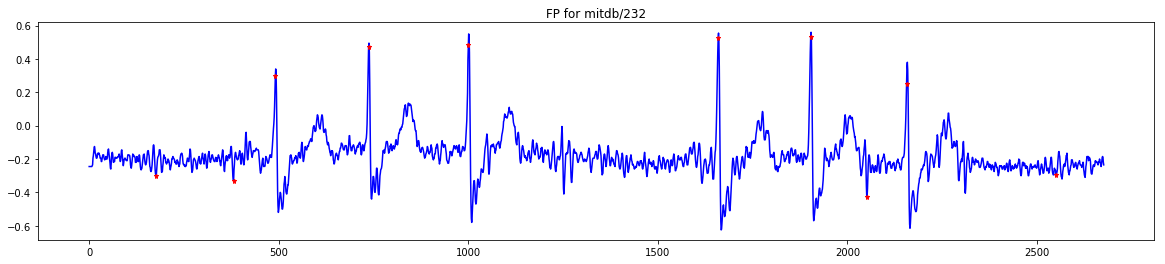

(650000,) (650000,) (0,)
(650000,) (650000,) (1,)


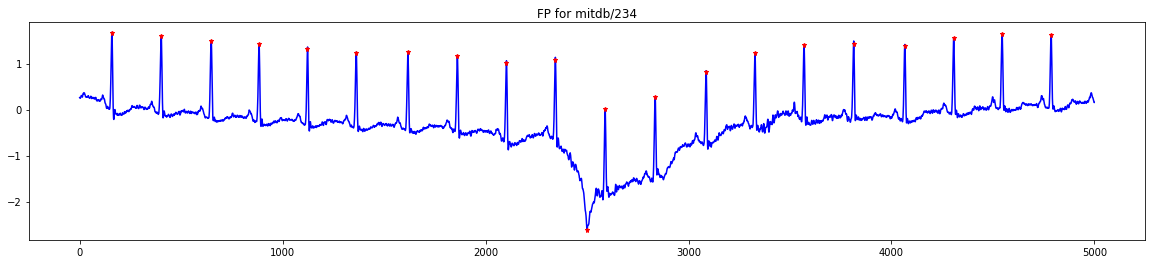

In [17]:
for ex in exs:
    x, ann, thresh, y_true, y_pred, rp, fp, fn = eval_example(data_dir, 'mitdb', ex, nn, params, border_size=0, nearest_fpr=0.001, eval_margin=20)
    print(x.shape, y_pred.shape, fp.shape)
    nrp = len(rp)
    nfp = len(fp)
    nfn = len(fn)
    if nfp > 0:        
        disp_range(x, y_pred, max(0, fp[0]-2500), min(x.shape[0], fp[0]+2500), title='FP for mitdb/' + ex)

In [ ]:
# def unstepize(y, expected_len, params):
#     segment_size = params['segment_size']
#     segment_step = params['segment_step']
#     N = len(y)
#     cut = int(segment_step/2)
    
#     res = numpy.empty(shape=(0), dtype=numpy.float32)
#     tmp = []
#     for i, e in enumerate(y):
#         if i == 0:
#             tmp.append(e[:cut+segment_step])
#         elif i == N-1:
#             remaining = expected_len - ((N-2)*segment_step + (segment_step+cut))
#             print(remaining)
#             assert remaining < params['segment_size']
#             tmp.append(e[-remaining:])
#         else:
#             tmp.append(e[cut:cut+segment_step])
#     res = numpy.concatenate(tmp, axis=0)
#     assert res.shape[0] == expected_len
#     return res

N = len(Y)
kk = (N-2)*params['segment_size']/2+(params['segment_size']*3/4)
print(x.shape[0]-kk, 'while expecting', x.shape[0])
y = unstepize(Y, x.shape[0], params)

print(y.shape)

In [8]:
print(x.shape, y.shape)
best_peaks_idxs = compute_best_peak(signal=x, rpeaks=y, min_gap=params['min_gap'], max_gap=params['max_gap'], threshold=0.99)
elapsed_secs = time.time() - t1
example_secs = x.shape[0]/fs
print('Computed in {}seconds (Computed {}x faster than ECG time)'.format(elapsed_secs, example_secs/elapsed_secs))

(20642000,) (20642000,)
Computed in 611.0379619598389seconds (Computed 135.12744729504527x faster than ECG time)


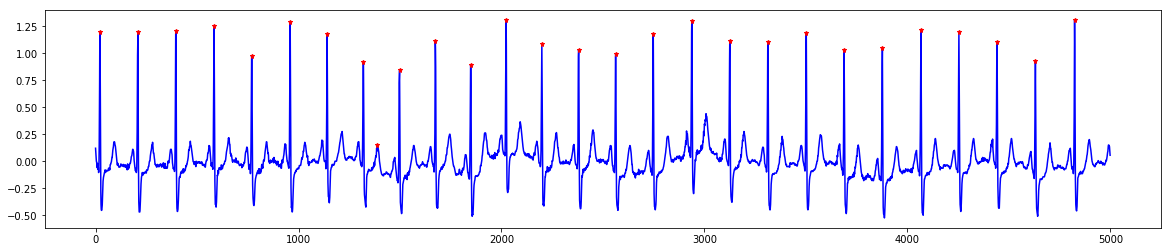

In [15]:
def disp_range(x, y, ann, lb, ub, threshold):
    x = x[lb:ub]
    y = y[lb:ub]
    cardiologist_idxs = ann.annsamp[numpy.where(numpy.logical_and(lb<=ann.annsamp, ann.annsamp<=ub))]
    best_peaks_idxs = compute_best_peak(signal=x, rpeaks=y, min_gap=params['min_gap'], max_gap=params['max_gap'], threshold=threshold)
    best_peaks_vals = x[best_peaks_idxs]
    plt.figure(figsize=(20, 4))
    plt.plot(x, 'b')
    plt.plot(best_peaks_idxs, best_peaks_vals, 'r*', markersize=5)
    plt.show()

m = 999
disp_range(x, y, ann, m*5000, (m+1)*5000, 0.99)

In [ ]:
disp_range(x, y, 100000, 120000, 0.99)

In [4]:
exs = shuffled_examples(databases, 360, 5000, 2500, True, True)
train_exs = exs[:int(len(exs)*train_perc/100)]
test_exs  = exs[int(len(exs)*train_perc/100):]
print('Number of examples: {} ({} samples)'.format(len(exs), len(exs)*5000))
print('          Training: {} ({} samples)'.format(len(train_exs), len(train_exs)*5000))
print('           Testing: {} ({} samples)'.format(len(test_exs), len(test_exs)*5000))

Number of examples: 12432 (62160000 samples)
          Training: 12307 (61535000 samples)
           Testing: 125 (625000 samples)


In [5]:
_, params = load_model('saved-models/170516-mit-sv-nsr-lt-sd/model-loss0.061288795094135894-epoch500.sav')
#print(params)
set_all_param_values(nn.model, params)
nn.init_funs(nn.model)

Evaluating..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

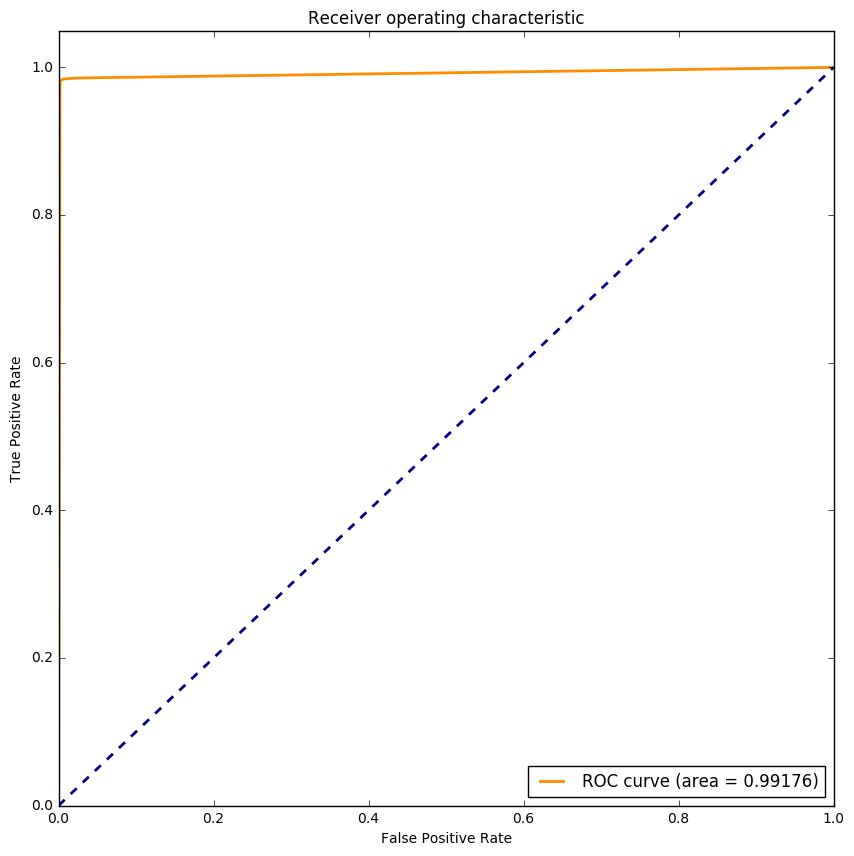

Samples:		60916800 samples
Beats:
  - 218180 labelized
  - 319954 detected
  - TP:  213861/218180
  - FP:  106093/0
  - TPR: 0.9802


In [8]:
nn.min_gap = min_gap
nn.max_gap = max_gap

eval_model(exs, nn.evaluate, nn.min_gap, nn.max_gap, nn.left_border, nn.right_border, *nn.params, exs=numpy.arange(len(exs)),
                       plot_examples=False, nb=None, nearest_fpr=0.005, threshold=0.999, eval_margin=10)

[    76     77     78 ..., 649735 649991 649992]


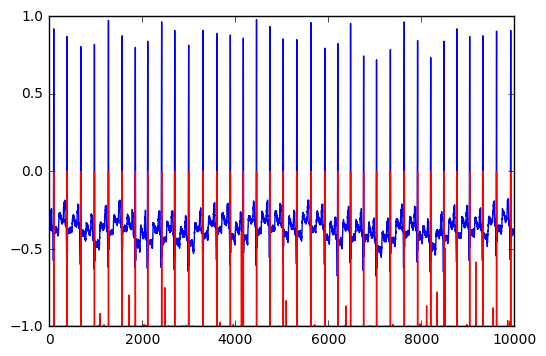

In [18]:
from preproc import *


def unstepize(y, segment_size, segment_step):
    N = len(y)
    cut = int(segment_step/2)
    
    res = None
    for i, e in enumerate(y):
        if i == 0:
            res = e[:cut+segment_step]
        elif i == N-1:
            res = numpy.concatenate((res, e[cut:]), axis=0)
        else:
            res = numpy.concatenate((res, e[cut:cut+segment_step]), axis=0)
    
    assert res.shape[0] == 2*(segment_step+cut)+(N-2)*segment_step
    return res

def compute_signal(x, nn, segment_size, segment_step, normalize_steps):
    def sigstepize(x, segment_size, segment_step, normalize_steps):
        assert x.shape[0] >= segment_size
        X = []
        for i in range(0, len(x)+1-segment_size, segment_step):
            if normalize_steps:
                xx = numpy.reshape(normalize(x[i:i+segment_size]), (segment_size, 1))
            else:
                xx = numpy.reshape(x[i:i+segment_size], (segment_size, 1))
            X.append(xx)
        assert len(X) == int(x.shape[0]/segment_step)-1
        return X
    
    Y = []
    for segment in sigstepize(x, segment_size, segment_step, normalize_steps):
        res = nn.evaluate(numpy.reshape(segment, (1, 1, segment_size)))
        res = res[0][0]
        Y.append(res)
        
    YY = unstepize(Y, segment_size, segment_step)
    return YY
        


f = 'data/mitdb/100'
sig, fields = wfdb.srdsamp(f)
fs = fields['fs']
ann = wfdb.rdann(f, 'atr')

x = sig[:, 0]
Y = compute_signal(x, nn, 5000, 2500, True)

lb=40000
ub=50000
print(numpy.where(Y>=0.97)[0])
plt.plot(x[lb:ub])
plt.plot(Y[lb:ub]-1, 'r')
plt.show()

In [80]:
from prepostproc import normalize

def stepize_x(x, params):
    segment_size = params['segment_size']
    segment_step = params['segment_step']
    cut = int(segment_step / 2)
    normalize_steps = params['normalize_steps']
    assert x.shape[0] >= segment_size
    X = [x[0:segment_size]]
    
    nb_blue, remain = divmod(x.shape[0]-cut-segment_step, segment_step)
    
    for i in range(nb_blue):
        lb = (i+1)*segment_step
        ub = (i+1)*segment_step + segment_size
        X.append(x[lb:ub])
    
    if remain > 0:
        X.append(x[-segment_size:])
    
    if normalize_steps:
        X = [normalize(x) for x in X]
    
    return X

def unstepize(y, length, params):
    segment_size = params['segment_size']
    segment_step = params['segment_step']
    cut = int(segment_step/2)
    
    Y = [y[0][:cut+segment_step]]
    
    nb_blue, remain = divmod(length-cut-segment_step, segment_step)
    
    for i in range(nb_blue):
        Y.append(y[i+1][cut:cut+segment_step])
    
    if remain > 0:
        Y.append(y[-1][-remain:])
    
    result = numpy.concatenate(Y)
    print(result.shape, length)
    assert result.shape[0] == length
    
    return result
    
import wfdb


f = 'data/mitdb/100'
sig, fields = wfdb.srdsamp(f)
fs = fields['fs']
ann = wfdb.rdann(f, 'atr')
params['normalize_steps'] = False
for z in range(648000, 650000, 1000):
    a = sig[:z,0]
    b = unstepize(stepize_x(sig[:z,0], params), z, params)
    assert numpy.all(a == b)

(648000,) 648000
(649000,) 649000


In [52]:
'{:>15}'.format('lol')

'            lol'